# Ribosome Stalling Sites

First, create the infrastructre for the analysis.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%capture
import sys
sys.path.insert(0, '/home/raf_pc/Kemal/RiboSeqAnalysis')
from infrastructure.main import *

# Working environment
temp_repo_dir = "/home/raf_pc/Kemal/Temp"
data_repo_dir = "/home/raf_pc/Kemal/Data"

# SAM files for ribosome stalling data and coco assembly data
spt = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_TT1.sam", "60mer_TT2.sam"]]
sps = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_Rep1.sam", "60mer_Rep2.sam", "60mer_NoPK.sam"]]
coco_d = [os.path.join(data_repo_dir, "Coco", i) for i in ["Dis1.sam", "Dis2.sam"]]
coco_m = [os.path.join(data_repo_dir, "Coco", i) for i in ["Mono1.sam", "Mono2.sam"]]

# Exculude the gene below because it has over-expression problem.
exclude_genes = ["ENSG00000160789"]

# Create the infrastructure object
I = Infrastructre(temp_repo_dir, exclude_genes=exclude_genes, sixtymers=[spt, sps], coco=[coco_m, coco_d])

## Distribution of RPKM values in imported data

Let's check the relationship between two riboseq data, ideally control vs experiment pairs like sixtymers versus translatome.
<br>
Note: To draw loglog plot, zero values were removed.

In [3]:
import statsmodels.api as sm
from scipy import stats 
import seaborn as sns
from matplotlib import gridspec

def compare_two_riboseq(arr1, arr2, narr1, narr2, general=None): # translatome, sixtymers:
    # Plot the result as histograms
    fig = plt.figure(figsize=(12, 5)) 
    if general: fig.suptitle(general, y=1.05, fontweight="bold")
    gs = fig.add_gridspec(1, 2, width_ratios=[1.25, 1])
    axes0 = plt.subplot(gs[0])
    axes0.set_yscale('log')
    axes0.set_ylabel('Gene count')
    axes0.set_xlabel(f'RPKM')
    values = np.concatenate([arr1,arr2])
    labels = np.array([narr1] * len(arr1) + [narr2] * len(arr2))
    df_temp = pd.DataFrame.from_dict(dict(zip(["RPKM", "Label"], [values, labels])))
    sns.histplot(df_temp, x="RPKM", hue="Label", multiple="dodge", ax=axes0, bins=30)
    
    # Fit the linear line to the loglog
    non_zero = np.intersect1d(np.nonzero(arr1), np.nonzero(arr2))
    arr1_log = np.log10(arr1[non_zero])
    arr2_log = np.log10(arr2[non_zero])
    results = sm.OLS(arr2_log, sm.add_constant(arr1_log)).fit()
    x_data_log = np.linspace(arr1_log.min(), arr1_log.max(), 1000)
    y_data_log = x_data_log * results.params[1] + results.params[0]

    # Plot the result
    axes1 = plt.subplot(gs[1])
    axes1.set_xlabel(f"{narr1} RPKM (x)")
    axes1.set_ylabel(f"{narr2} RPKM (y)")
    axes1.set_xscale('log')
    axes1.set_yscale('log')
    axes1.scatter(x=arr1[non_zero], y=arr2[non_zero], marker='.', edgecolors='none')
    axes1.plot(10**x_data_log, 10**y_data_log, color="black")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
    textstr = '\n'.join((
        r'$log_{10}(y)=log_{10}(x)*%.2f + %.2f$' % (results.params[1], results.params[0]),
        r'$y=x^{%.2f}*10^{%.2f}$' % (results.params[1], results.params[0]),
        r'$R^2=%.2f$' % (results.rsquared,),
        ))
    axes1.text(0.025, 0.975, textstr, transform=axes1.transAxes, verticalalignment='top', horizontalalignment="left", bbox=props, alpha=1)
    plt.tight_layout()
    plt.show()
    
    # Check the correlation between RPKM values of translatome and experiment for sixytmer data
    corr_nonzero = stats.pearsonr(tt_rpkms[non_zero], ex_rpkms[non_zero])
    corr_all = stats.pearsonr(tt_rpkms, ex_rpkms)
    print("Pearson correlation (only nonzero): %.4f, where p=%.2f" % (corr_nonzero[0], corr_nonzero[1]))
    print("Pearson correlation (all): %.4f, where p=%.2f" % (corr_all[0], corr_all[1]))

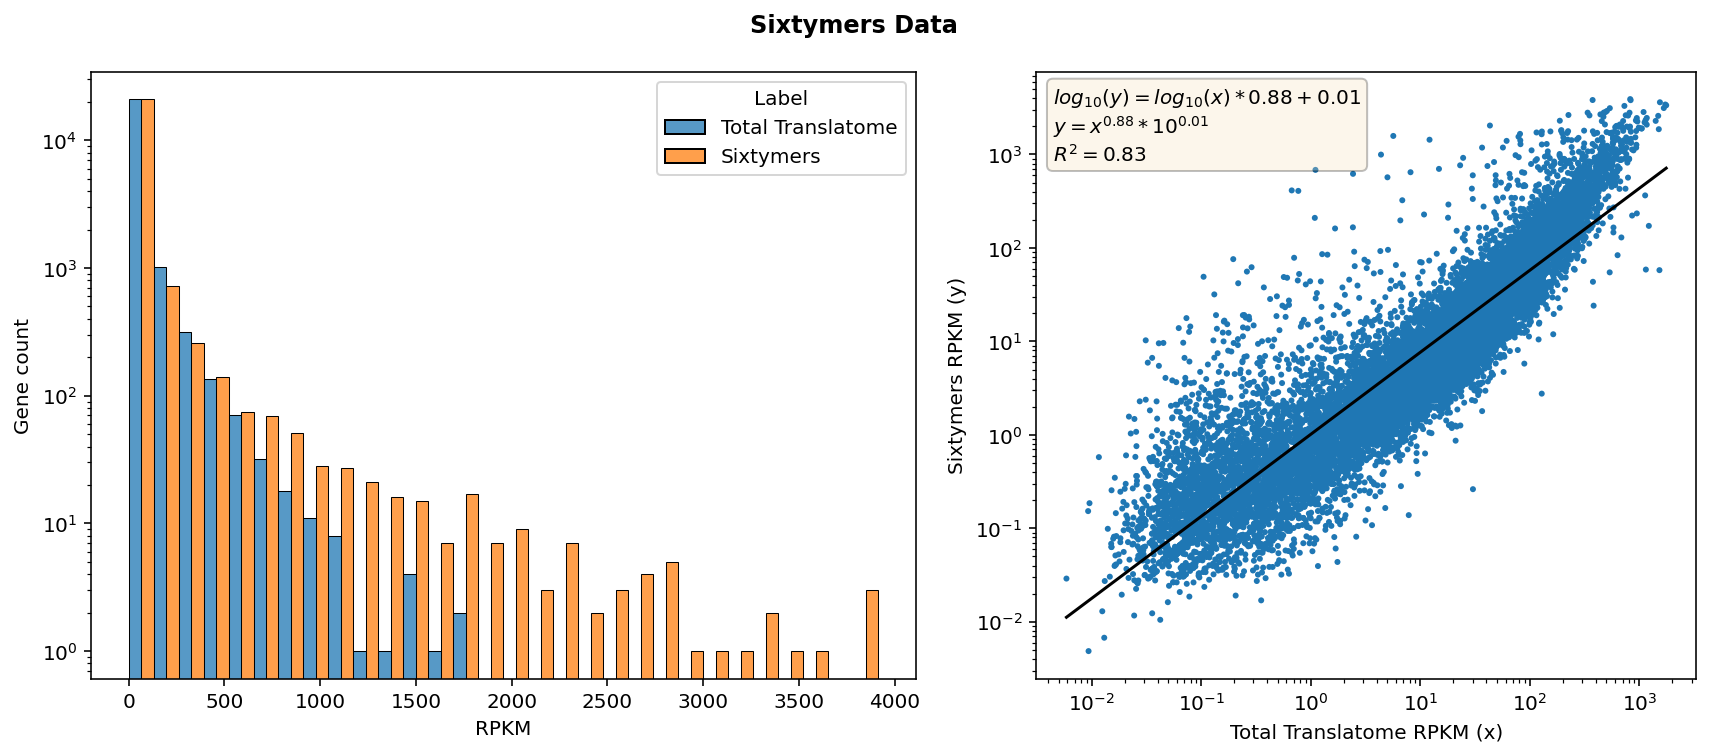

Pearson correlation (only nonzero): 0.7761, where p=0.00
Pearson correlation (all): 0.7807, where p=0.00


In [4]:
# Get the total translatome and experiment RPKM values for sixytmer data.
tt_rpkms = np.array([I.riboseq_sixtymers.translatome.calculate_rpkm_genes(g) for g in I.gene_list])
ex_rpkms = np.array([I.riboseq_sixtymers.experiment.calculate_rpkm_genes(g) for g in I.gene_list])
compare_two_riboseq(tt_rpkms, ex_rpkms, "Total Translatome", "Sixtymers", "Sixtymers Data")

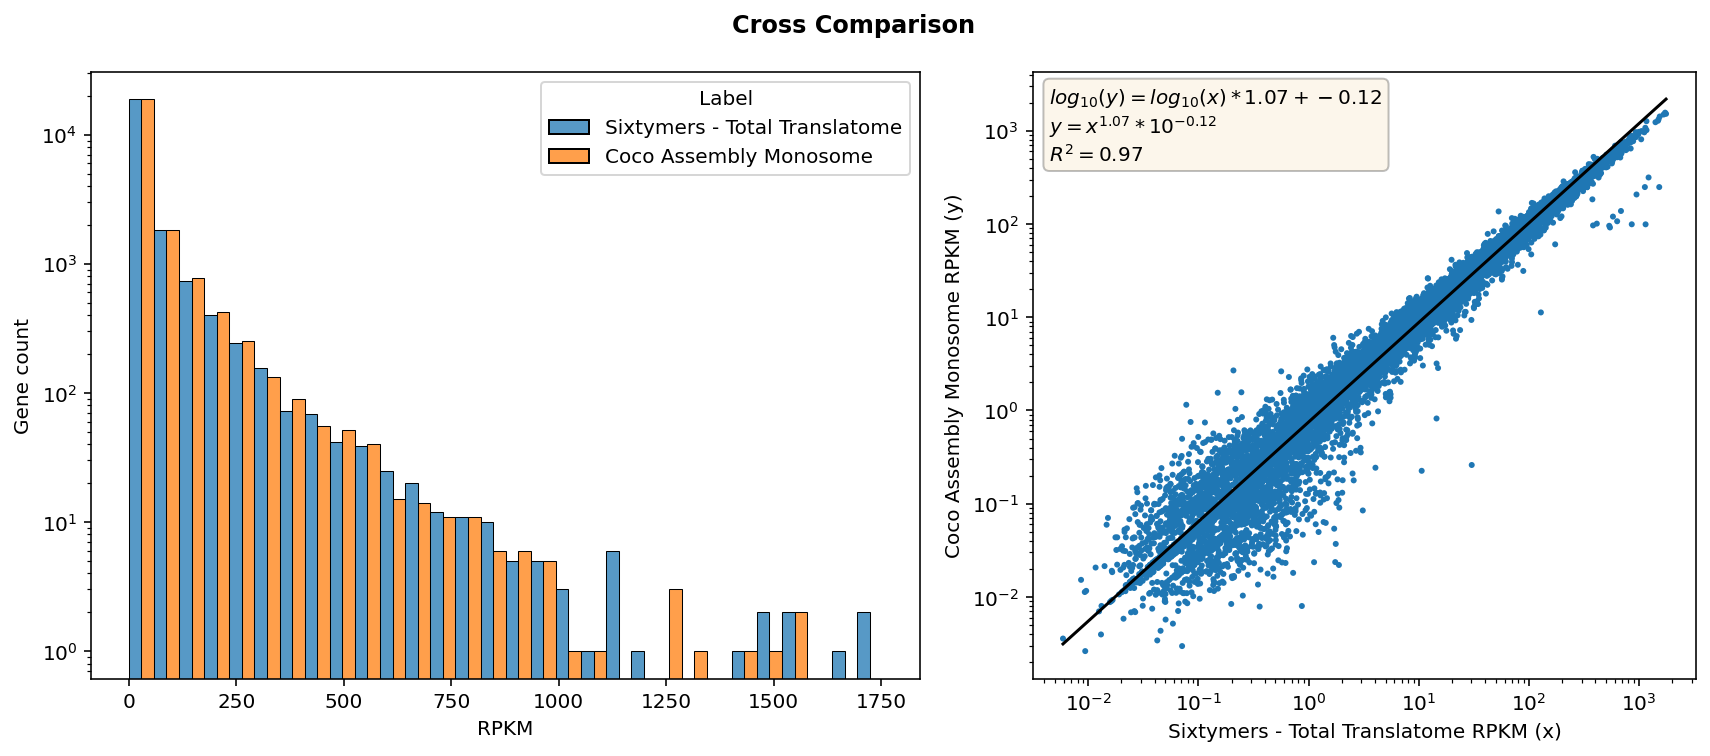

Pearson correlation (only nonzero): 0.7761, where p=0.00
Pearson correlation (all): 0.7807, where p=0.00


In [5]:
tt_si_rpkms = np.array([I.riboseq_sixtymers.translatome.calculate_rpkm_genes(g) for g in I.gene_list])
tt_co_rpkms = np.array([I.riboseq_coco.translatome.calculate_rpkm_genes(g) for g in I.gene_list])
compare_two_riboseq(tt_si_rpkms, tt_co_rpkms, "Sixtymers - Total Translatome", "Coco Assembly Monosome", "Cross Comparison")

## De-noising algorithm and its parameters

Based on the results, it is possible to say that total translatome of the sixtymers data correlates perfectly with total monosome counts of coco assembly data. This suggest that total translatome data of sixtymers represents the gene as perfectly. However, this values are for RPKM, which does not strictly mean that we will see the same phenomena in gene positions. It is possible to compare two dataset's in terms of correlation of RPM values in gene positions, but the noise in the sequencing fragment position could make the correlation work insuccessfully. For this reason, it is necessary to find out a function which denoises the arrays (RPM values from a given gene), so that the comparison will be much robust. 

In [6]:
window_types = ('flat', 'hanning', 'hamming', 'bartlett', 'blackman')
window_range = np.arange(3, 121, 2)
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_mad_msd_smoothen_window.joblib")
try:  # Because it takes very long, as written very inefficiently.
    all_mad, all_msd = joblib.load(save_metadata_path)
except FileNotFoundError:
    all_mad, all_msd = list(), list()
    for window in window_types:
        genome_response_mad, genome_response_msd = list(), list()
        for gene_id in I.gene_list:
            coco_rpkm = I.riboseq_coco.translatome.calculate_rpkm_genes(gene_id)
            sixt_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
            if coco_rpkm > 1 and sixt_rpkm > 1:
                coco_rpm_bf = I.riboseq_coco.translatome.calculate_rpm_positions(gene_id)
                sixt_rpm_bf = I.riboseq_sixtymers.translatome.calculate_rpm_positions(gene_id)
                gene_response_mad, gene_response_msd = list(), list()
                for window_len in window_range:
                    try:
                        coco_rpm = smooth_array(coco_rpm_bf, window_len=window_len, window=window)
                        sixt_rpm = smooth_array(sixt_rpm_bf, window_len=window_len, window=window)
                        c_mad = np.sum(np.abs(coco_rpm - sixt_rpm))/len(coco_rpm)  # mean absolute deviation
                        c_msd = np.sqrt(np.sum(np.power(coco_rpm - sixt_rpm, 2))/len(coco_rpm))  # mean square deviation
                    except AssertionError:
                        c_mad, c_msd = np.nan, np.nan
                    gene_response_mad.append(c_mad)
                    gene_response_msd.append(c_msd)
                genome_response_mad.append(gene_response_mad)
                genome_response_msd.append(gene_response_msd)
        all_mad.append(genome_response_mad)
        all_msd.append(genome_response_msd)
    joblib.dump((all_mad, all_msd), save_metadata_path)

Let's plot the result. I get the MAD or MSD values of all genes (which has RPKM>1 in coco translatome and sixtymer translatome) for a given window type. Then, I calculated the mean for a given window length. The curves were drawn based on the mean MAD/MSD for all genes for given window length. Elbow points were calculated by a kneed package, which is an attempt to implement the kneedle algorithm. I selected the elbow point for the optimal window length. Confidence intervals are also shown as the shaded area.

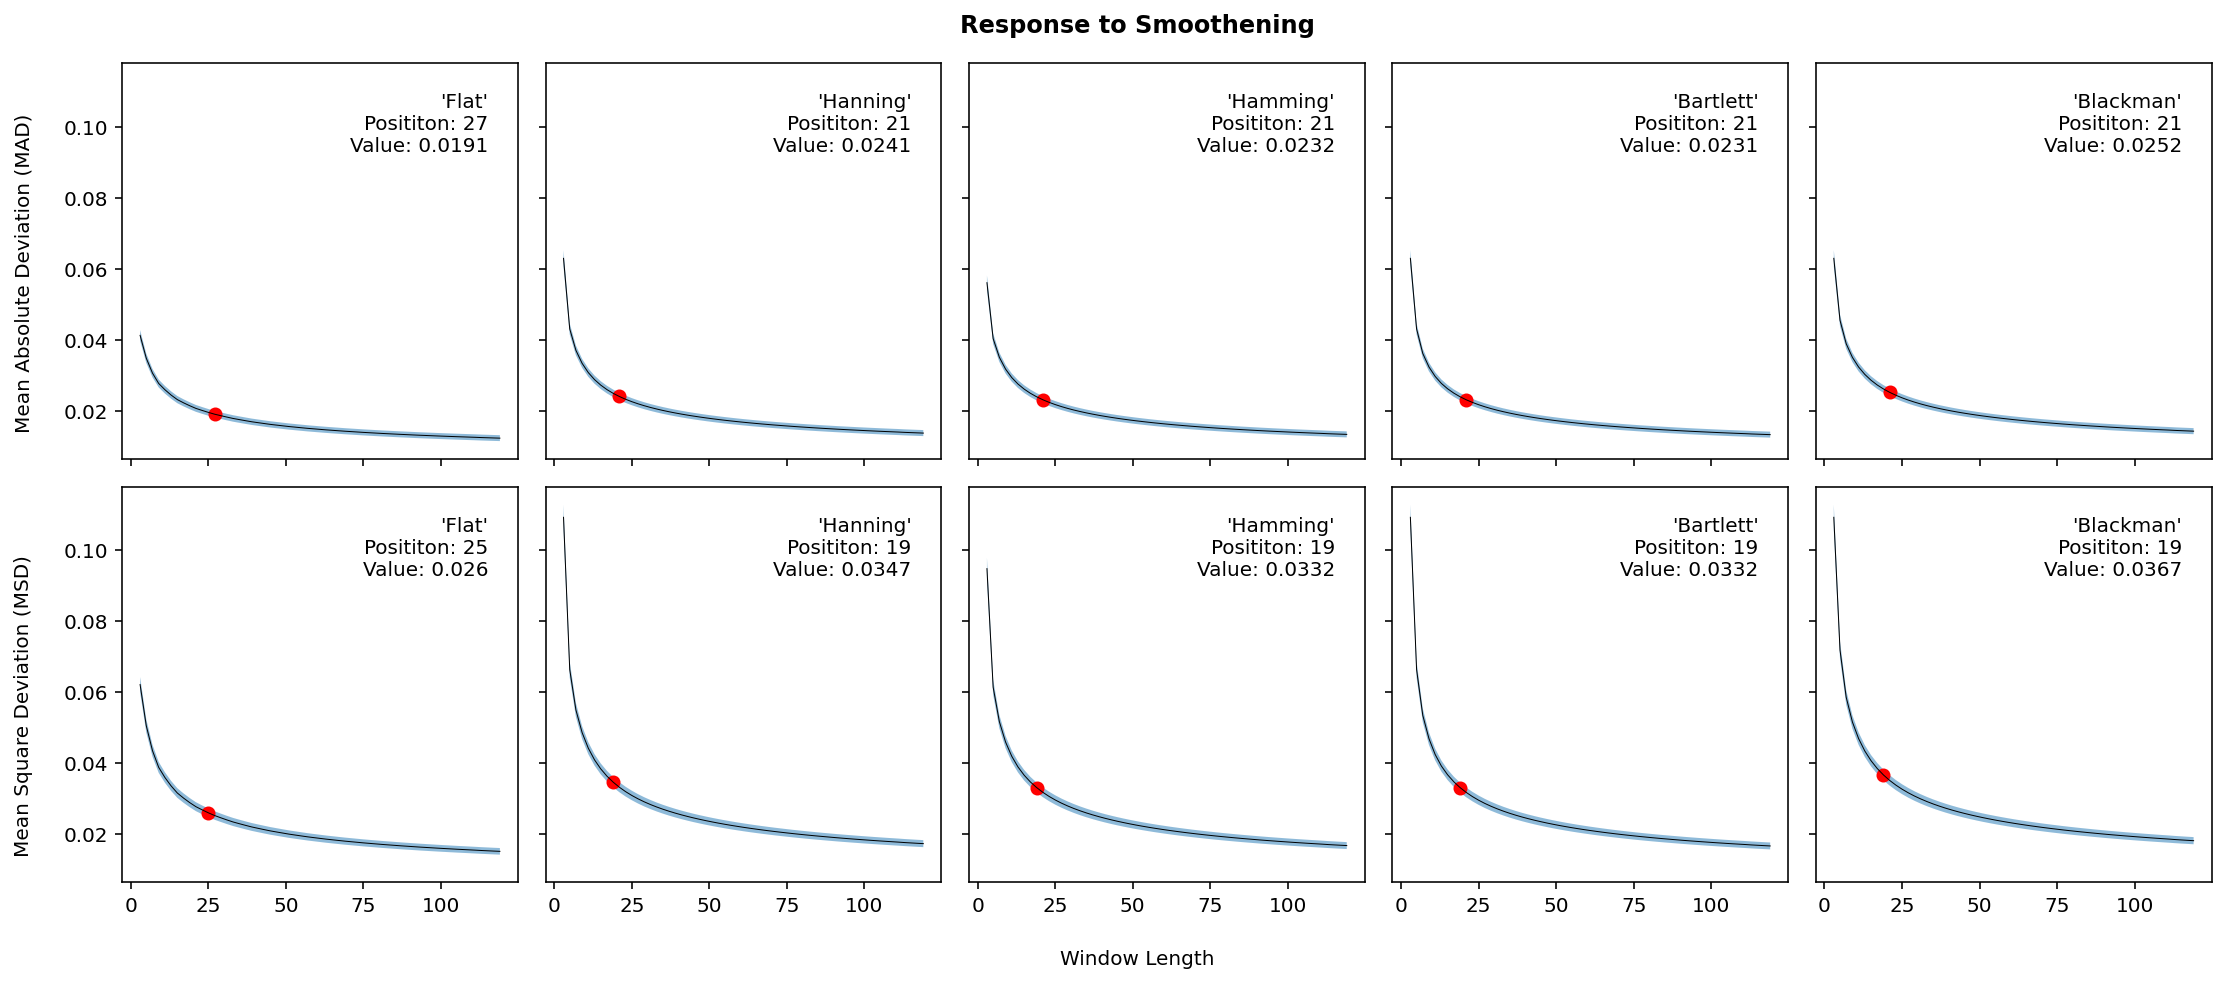

In [7]:
from kneed import KneeLocator
fig, ax = plt.subplots(2,5, figsize=(15, 6), sharex=True, sharey=True, constrained_layout=True) 
plt.suptitle("Response to Smoothening", y=1.05, fontweight="bold")
x_data = window_range
x_labels = ["Mean Absolute Deviation (MAD)", "Mean Square Deviation (MSD)"]
CONFIDENCE = 0.999
for j, the_one in enumerate([all_mad, all_msd]):
    for k, window in enumerate(window_types):
        arr = np.array(the_one[k])
        # Statistics
        y_data = np.nanmean(arr, axis=0)
        se = np.array(stats.sem(arr, nan_policy='omit')) # standard error
        n = len(arr) - np.sum(np.isnan(arr), axis=0)
        ci_l, ci_h = stats.t.interval(CONFIDENCE, n-1, loc=y_data, scale=se)
        # Find elbow
        kn = KneeLocator(x_data, y_data, curve='convex', direction='decreasing')
        knee_x, knee_y = kn.knee, kn.knee_y
        # Plot
        ax[j][k].plot(x_data, y_data, linewidth=0.5, color="black")
        ax[j][k].fill_between(x_data, ci_l, ci_h, alpha=0.5)      
        ax[j][k].scatter(knee_x, knee_y, color="red")
        ax[j][k].text(0.925, 0.925, f"'{window.capitalize()}'\nPosititon: {knee_x}\nValue: {round(knee_y,4)}", transform=ax[j][k].transAxes, verticalalignment='top', horizontalalignment="right", alpha=1)
fig.text(0.5, - 0.05, 'Window Length', ha='center')
fig.text(-0.02, 0.75, x_labels[0], va='center', rotation='vertical')
fig.text(-0.02, 0.25, x_labels[1], va='center', rotation='vertical')
plt.show()

Quoting from Huber, Robust Statistics, p.10, "There was a dispute between Eddington (1914, p.147) and Fisher (1920, footnote on p. 762) about the relative merits of MAD and MSD. [...] Fisher seemingly settled the matter by pointing out that for normal observations MSD is about 12% more efficient than MAD". For this reason, MSD and 'flat' window type with window length of 25. I believe this number will remove the noise while preserving the details. Besides, after smooting with 'flat', two results can be comparable.

## Peak Prioritization

### Smooth while preserve peaks

In [8]:
from scipy.signal import find_peaks
window_types = ('flat', 'hanning', 'hamming', 'bartlett', 'blackman')
window_range = np.arange(3, 111, 2)
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_smoothen_window_peak_detection.joblib")
try:  # Because it takes very long, as written very inefficiently.
    all_peak = joblib.load(save_metadata_path)
except FileNotFoundError:
    all_peak = list()
    for window in window_types:
        genome_response_peak = list()
        for gene_id in I.gene_list:
            exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
            tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
            if exp_rpkm > 1 and tra_rpkm > 1:
                exp_rpm_bf = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
                window_list = list()
                for window_len in window_range: 
                    try:
                        exp_rpm_s = smooth_array(exp_rpm_bf, window_len=window_len, window=window)
                        calc = len(find_peaks(exp_rpm_s)[0]) / len(exp_rpm_s) * 1000  # number of peaks detected
                    except AssertionError:
                        calc = np.nan
                    window_list.append(calc)
                genome_response_peak.append(window_list)
        all_peak.append(genome_response_peak)
    all_peak = np.array(all_peak)
    joblib.dump(all_peak, save_metadata_path)

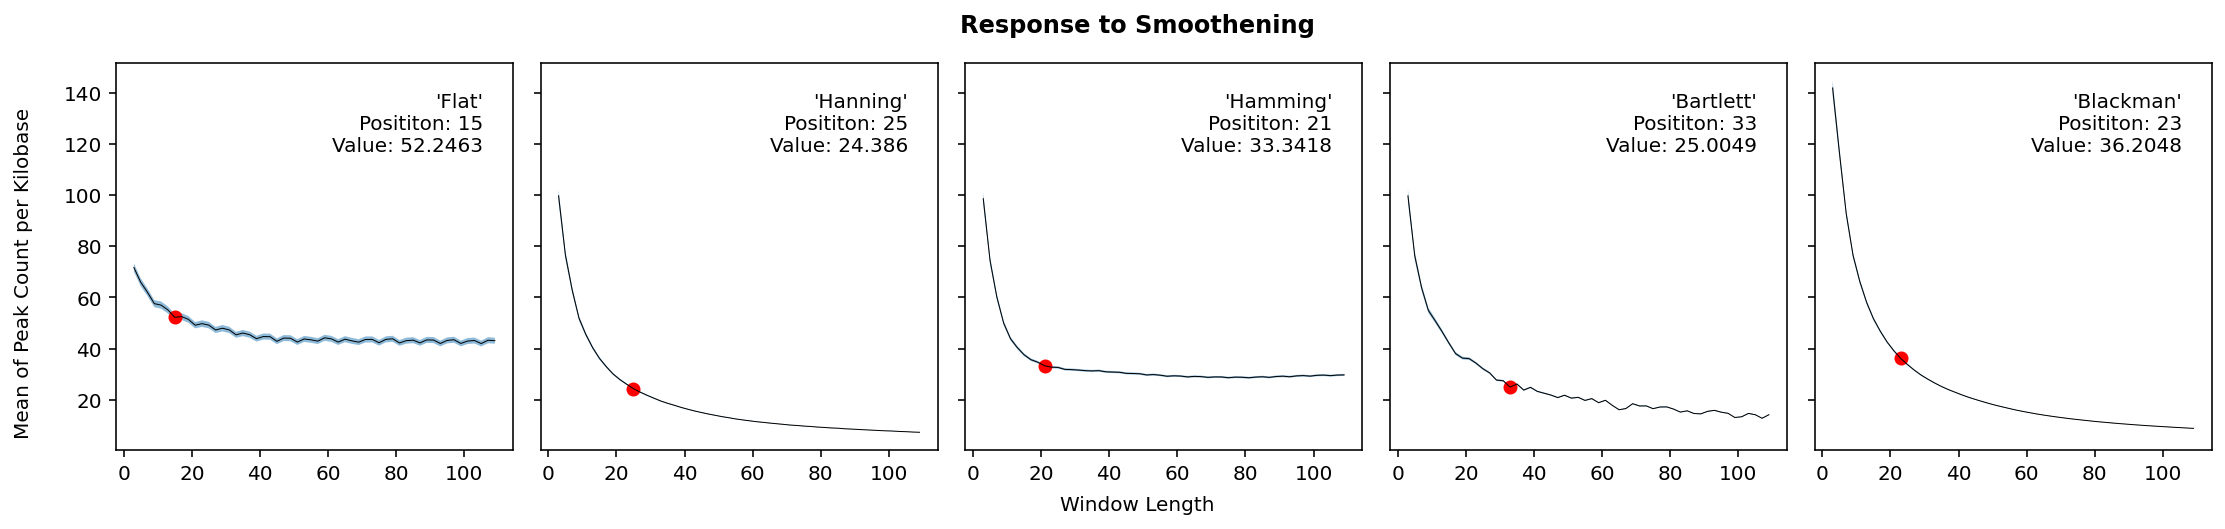

In [9]:
from kneed import KneeLocator
fig, ax = plt.subplots(1,5, figsize=(15, 3), sharex=True, sharey=True, constrained_layout=True) 
plt.suptitle("Response to Smoothening", y=1.1, fontweight="bold")
x_data = window_range
CONFIDENCE = 0.999
for k, window in enumerate(window_types):
    arr = np.array(all_peak[k])
    # Statistics
    y_data = np.nanmean(arr, axis=0)
    se = np.array(stats.sem(arr, nan_policy='omit')) # standard error
    n = len(arr) - np.sum(np.isnan(arr), axis=0)
    ci_l, ci_h = stats.t.interval(CONFIDENCE, n-1, loc=y_data, scale=se)
    # Find elbow
    kn = KneeLocator(x_data, y_data, curve='convex', direction='decreasing')
    knee_x, knee_y = kn.knee, kn.knee_y
    # Plot
    ax[k].plot(x_data, y_data, linewidth=0.5, color="black")
    ax[k].fill_between(x_data, ci_l, ci_h, alpha=0.5)        
    ax[k].scatter(knee_x, knee_y, color="red")
    ax[k].text(0.925, 0.925, f"'{window.capitalize()}'\nPosititon: {knee_x}\nValue: {round(knee_y,4)}", transform=ax[k].transAxes, verticalalignment='top', horizontalalignment="right", alpha=1)
fig.text(0.5, - 0.05, 'Window Length', ha='center')
fig.text(-0.02, 0.5, "Mean of Peak Count per Kilobase", va='center', rotation='vertical')
plt.show()

This means, 'hanning' smoothing with window length 25 will be the choice. I only tried convolutional smoothing with various window types. For now, I will move forward with this one, but please note that there could be many option for this step. Some of them are:
- Low pass Butterworth filter
- Forrier transform and get a slice
- Using other kernels like gaussian kernel
- Wiener filter, scipy filters like lfilter, Kalman filter
- tsmoothie package

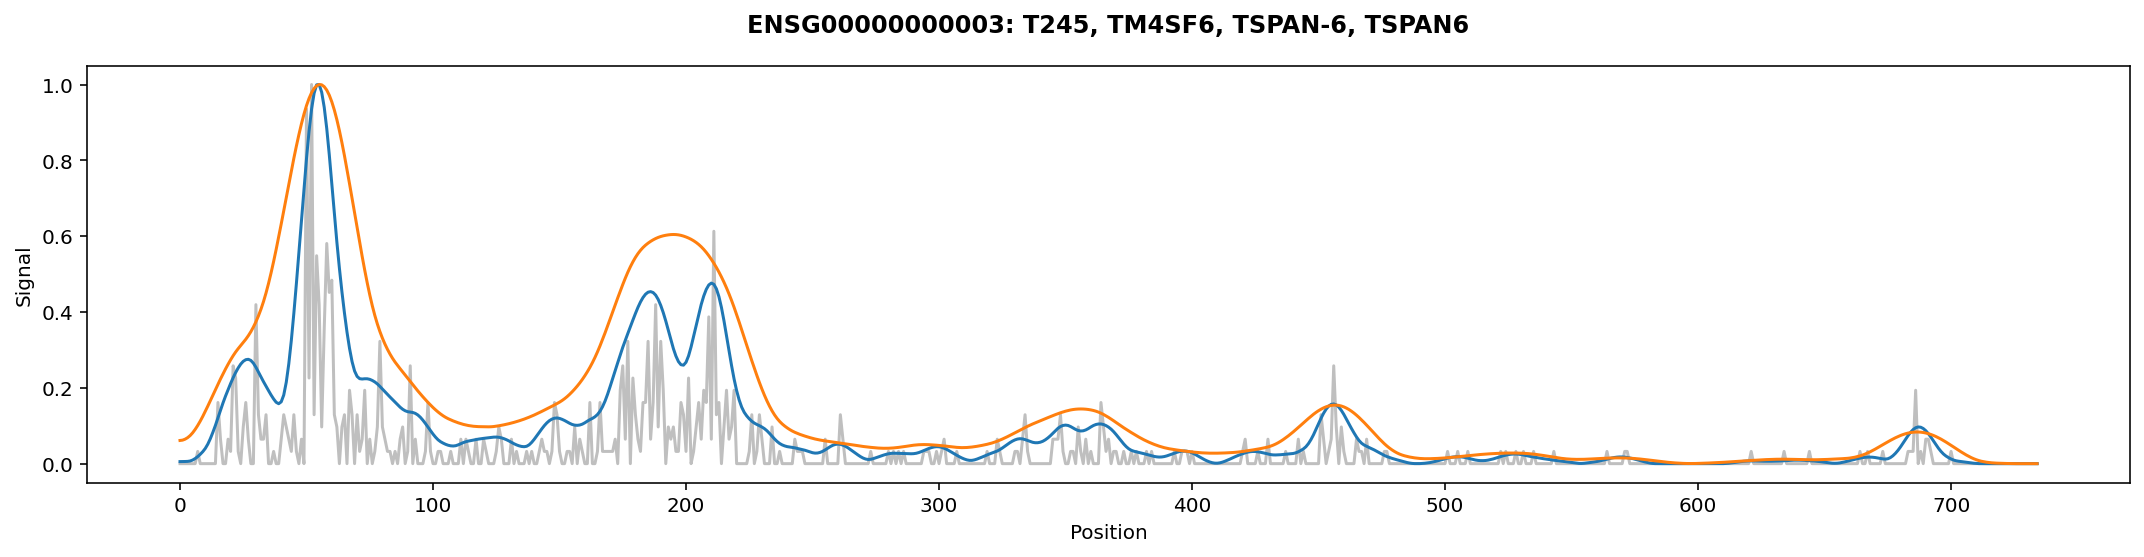

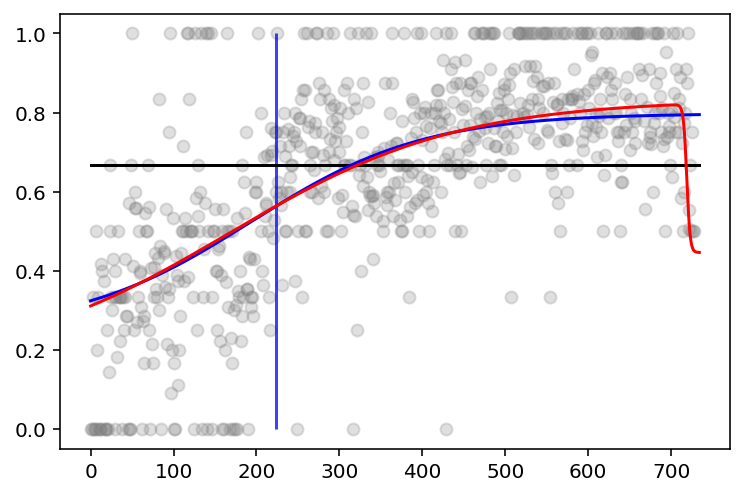

Winner: dsig
Onset: 224


In [10]:
# Example:
gene_id = I.gene_list[0]
# Check 0, 7, 11
# Check 30 for single peak. Compare with 25
gene_rpm_vals = np.mean(I.riboseq_sixtymers.experiment.gene_assignments[gene_id], axis=0)
smooth1 = smooth_array(gene_rpm_vals, window="hanning", window_len = 25)
smooth2 = smooth_array(gene_rpm_vals, window="hanning", window_len = 55)
fig = plt.figure(figsize=(15, 4))
plt.plot(gene_rpm_vals / gene_rpm_vals.max(), alpha=0.5, color="gray")
plt.plot(smooth1 / smooth1.max()); plt.plot(smooth2 / smooth2.max())
plt.ylabel("Signal"); plt.xlabel("Position")
gene_names = ", ".join(I.gene_info[gene_id].gene_names)
plt.title(f"{gene_id}: {gene_names}", y=1.05, fontweight="bold")
plt.tight_layout(); plt.show()
I.riboseq_coco.plot_result(gene_id)

### Peak Detection 1: 

Global threshold for peak height. RPM values for gene positions are normalized by gene translatome RPM value, like Arpat et. al. did, but not pairwise position normalization.

In [11]:
peak_heights = list()
window_len = 25
for gene_id in I.gene_list:
    exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
    tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
    if exp_rpkm > 1 and tra_rpkm > 1:
        exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        # normalize with translatome rpm
        rpm_gene = I.riboseq_sixtymers.translatome.calculate_rpm_genes(gene_id)
        if len(exp_rpm_bs) > window_len:
            exp_rpm_s = smooth_array(exp_rpm_bs, window_len=window_len, window="hanning") / rpm_gene
            peak_heights.append(exp_rpm_s[find_peaks(exp_rpm_s)[0]])
print(f"Number of gene: {len(peak_heights)}")
peak_heights = np.concatenate(peak_heights, axis=0)

Number of gene: 11649


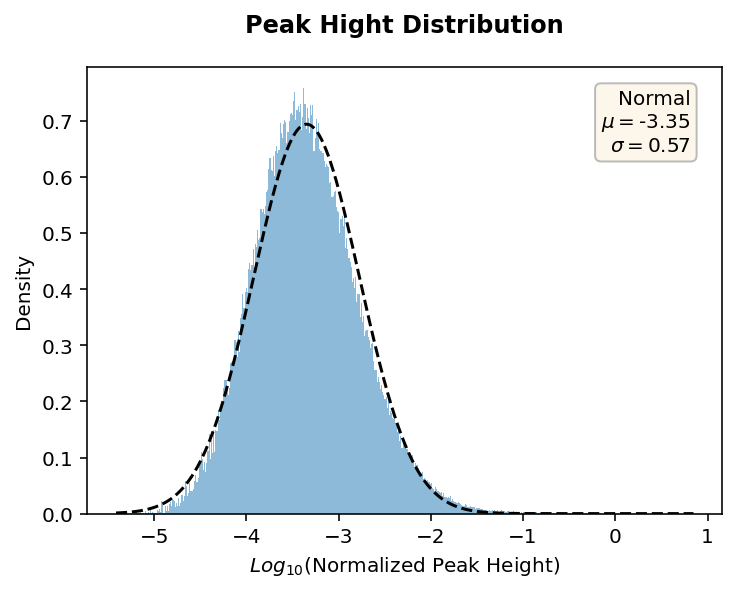

In [12]:
log_peak_height = np.log10(peak_heights)
log_peak_height_for_1 = log_peak_height.copy()  # for later use
fit_mu, fit_std  = stats.norm.fit(log_peak_height)
x_data_mock = np.linspace(log_peak_height.min(), log_peak_height.max(), 1000)
y_data_fit = stats.norm.pdf(x_data_mock, fit_mu, fit_std)
fig, ax = plt.subplots(1,1, figsize=(5, 4), constrained_layout=True) 
ax.set_title("Peak Hight Distribution", fontweight="bold", y=1.05)
ax.set_xlabel(r"$Log_{10}$(Normalized Peak Height)")
ax.set_ylabel(f"Density")
ax.hist(log_peak_height, density=True, bins=512, alpha=0.5)
ax.plot(x_data_mock, y_data_fit, color="black", linestyle='--')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
textstr = "Normal\n" + '\n'.join((r'$\mu=$%.2f' % fit_mu, r'$\sigma=$%.2f' % fit_std))
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, verticalalignment='top', horizontalalignment="right", bbox=props, alpha=1)
plt.show()

In [13]:
def peak_detection_inecik_1(gene_id, threshold, window="hanning", window_len=25):
    try:
        exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
        tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
        exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        assert exp_rpkm > 1 and tra_rpkm > 1
        assert len(exp_rpm_bs) > window_len
        rpm_gene = I.riboseq_sixtymers.translatome.calculate_rpm_genes(gene_id)
        exp_rpm_s = smooth_array(exp_rpm_bs, window_len=window_len, window=window) / rpm_gene
        peaks = find_peaks(exp_rpm_s)[0]
        peak_values = exp_rpm_s[peaks]
        peak_values_thresholded = np.log10(peak_values) > threshold
        return peaks[peak_values_thresholded]
    except AssertionError:
        return np.array([])

In [14]:
# Example usage
gene_id = I.gene_list[0]
threshold_1 = np.percentile(log_peak_height_for_1, 95)
peaks_example = peak_detection_inecik_1(gene_id, threshold_1)
print(f"Peaks for {gene_id}: {peaks_example}")
print(f"Threshold: {round(threshold_1, 4)}")

Peaks for ENSG00000000003: [ 54 210]
Threshold: -2.3633


### Peak Detection 2: 

Global threshold for peak height times peak prominence, considering peak as a triangle and calculating the area. RPM values for gene positions are normalized by gene translatome RPM value, but not pairwise position normalization.

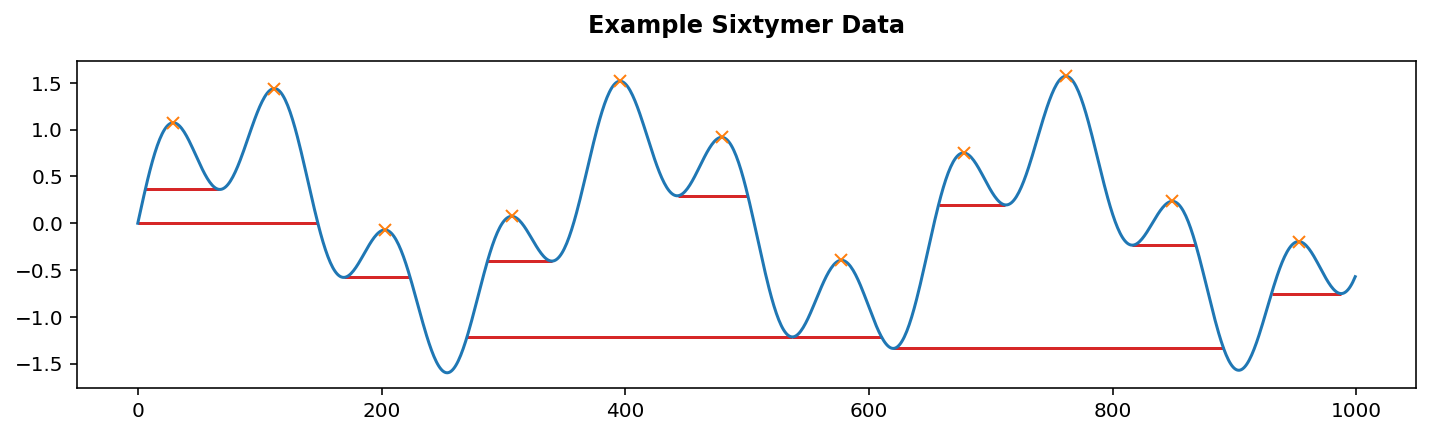

In [15]:
from scipy.signal import find_peaks, peak_widths, peak_prominences
x = np.linspace(0, 6 * np.pi, 1000)
x = np.sin(x) + 0.6 * np.sin(3.6 * x)
peaks, _ = find_peaks(x)
results_full = peak_widths(x, peaks, rel_height=1, wlen=290)
fig = plt.figure(figsize=(12,3))
plt.plot(x)
plt.title("Example Sixtymer Data", fontweight="bold", y=1.05)
plt.plot(peaks, x[peaks], "x")
plt.hlines(*results_full[1:], color="C3")
plt.show()

The aim of this method is based on calculating triangular area covered by the peak width and peak prominence. This will allow us to get rid of the noise in the peaks. Since it also takes the width, it should be more robust method in terms of biological relevance. Prominence measures how much a peak stands out from the surrounding baseline of the signal and is defined as the vertical distance between the peak and its lowest contour line. For this reason, background signal will be canceled out automatically.

Here, 'wlen' is a parameter that should be optimized, because a large wlen cause data. 

#### Parameter optimization for 'wlen'

This assume that, as we increase the value of wlen, we expect to see peaks with much longer width. The elbow point will help us select an optimal 'wlen'.

In [16]:
wlen_range = np.arange(40, 1200, 10)
wlen_optimize = list()
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_wlen_parameter_peak_detection.joblib")
try:  # Because it takes very long, as written very inefficiently.
    wlen_optimize = joblib.load(save_metadata_path)
except FileNotFoundError:
    for wlen in wlen_range:
        peak_width_all = list()
        for gene_id in I.gene_list:
            exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
            tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
            if exp_rpkm > 1 and tra_rpkm > 1:
                exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
                # normalize with translatome rpm
                rpm_gene = I.riboseq_sixtymers.translatome.calculate_rpm_genes(gene_id)
                if len(exp_rpm_bs) > window_len:
                    exp_rpm_s = smooth_array(exp_rpm_bs, window_len=25, window="hanning") / rpm_gene
                    peaks, _ = find_peaks(exp_rpm_s)
                    witdhs = peak_widths(exp_rpm_s, rel_height=1, peaks=peaks, wlen=wlen)
                    peak_width_all.extend(witdhs[0])
        wlen_optimize.append(peak_width_all)
    wlen_optimize = np.array(wlen_optimize)
    joblib.dump(wlen_optimize, save_metadata_path)

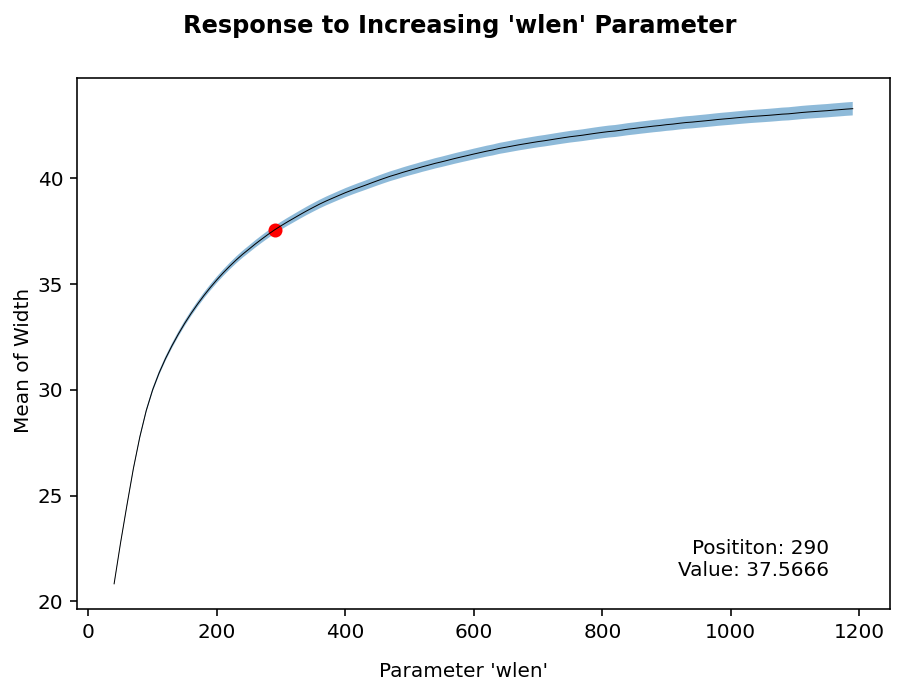

In [17]:
from kneed import KneeLocator
fig, ax = plt.subplots(1,1, figsize=(6, 4), sharex=True, sharey=True, constrained_layout=True) 
plt.suptitle("Response to Increasing 'wlen' Parameter ", y=1.1, fontweight="bold")
x_data = wlen_range
CONFIDENCE = 0.999
arr = wlen_optimize.T
# Statistics
y_data = np.nanmean(arr, axis=0)
se = np.array(stats.sem(arr, nan_policy='omit')) # standard error
n = len(arr) - np.sum(np.isnan(arr), axis=0)
ci_l, ci_h = stats.t.interval(CONFIDENCE, n-1, loc=y_data, scale=se)
# Find elbow
kn = KneeLocator(x_data, y_data, curve='concave', direction='increasing')
knee_x, knee_y = kn.knee, kn.knee_y
# Plot
ax.plot(x_data, y_data, linewidth=0.5, color="black")
ax.fill_between(x_data, ci_l, ci_h, alpha=0.5)        
ax.scatter(knee_x, knee_y, color="red")
ax.text(0.925, 0.055, f"Posititon: {knee_x}\nValue: {round(knee_y,4)}", transform=ax.transAxes, verticalalignment='bottom', horizontalalignment="right", alpha=1)
fig.text(0.5, - 0.05, "Parameter 'wlen'", ha='center')
fig.text(-0.02, 0.5, "Mean of Width", va='center', rotation='vertical')
plt.show()

As a result, wlen=290 is the value I want to move with.

#### Global threshold and the algorithm

Everything is similar to above, but this time aforementioned triangular area will be used for a peak. Here, I will try to find out a good thredhold for this. 

In [18]:
peak_calculation = list()
peak_prominences_for_pd_4 = list()
for gene_id in I.gene_list:
    exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
    tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
    if exp_rpkm > 1 and tra_rpkm > 1:
        exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        # normalize with translatome rpm
        rpm_gene = I.riboseq_sixtymers.translatome.calculate_rpm_genes(gene_id)
        if len(exp_rpm_bs) > window_len:
            exp_rpm_s = smooth_array(exp_rpm_bs, window_len=25, window="hanning") / rpm_gene
            peaks, _ = find_peaks(exp_rpm_s)
            calc_prominences = peak_prominences(exp_rpm_s, peaks=peaks, wlen=290)
            calc_witdhs = peak_widths(exp_rpm_s, rel_height=1, peaks=peaks, prominence_data=calc_prominences, wlen=290)
            peak_calculation.append(calc_prominences[0] * calc_witdhs[0])
            peak_prominences_for_pd_4.extend(list(calc_prominences[0]))
print(f"Number of gene: {len(peak_calculation)}")
peak_calculation = np.concatenate(peak_calculation, axis=0)
peak_prominences_for_pd4_log = np.log10(np.array(peak_prominences_for_pd_4))  # For later use

Number of gene: 11649


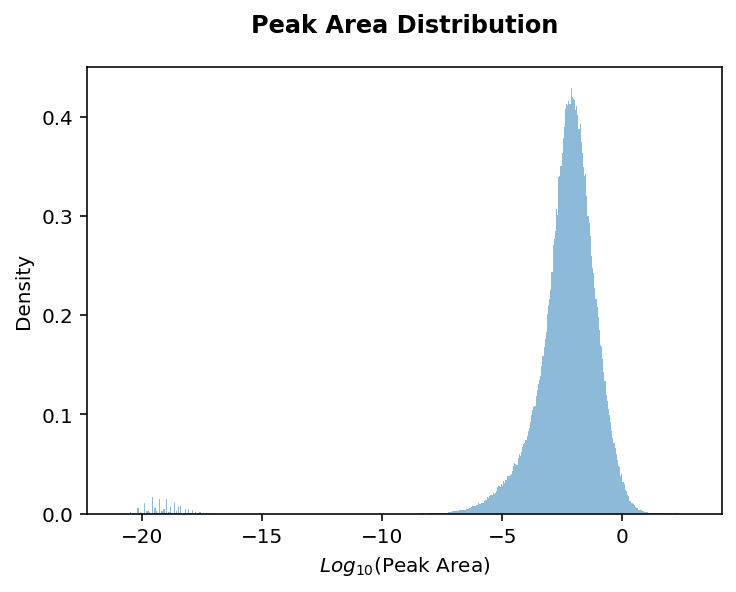

In [19]:
log_peak_height = np.log10(peak_calculation)
log_peak_height_for_2 = log_peak_height.copy()  # for later use
# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True) 
ax.set_title("Peak Area Distribution", fontweight="bold", y=1.05)
ax.set_xlabel(r"$Log_{10}$(Peak Area)")
ax.set_ylabel(f"Density")
ax.hist(log_peak_height, density=True, bins=512, alpha=0.5)
plt.show()

I calculated fitting by running 'universal_fitter' function first, which enabled me to know which probability distribution best represents the data. Note that I do not use the parameters and the fit for this method.

In [20]:
def peak_detection_inecik_2(gene_id, threshold, window="hanning", window_len=25, wlen=290):
    try:
        exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
        tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
        exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        assert exp_rpkm > 1 and tra_rpkm > 1
        assert len(exp_rpm_bs) > window_len
        rpm_gene = I.riboseq_sixtymers.translatome.calculate_rpm_genes(gene_id)
        exp_rpm_s = smooth_array(exp_rpm_bs, window_len=window_len, window=window) / rpm_gene
        # Calculations
        peaks, _ = find_peaks(exp_rpm_s)
        calc_prominences = peak_prominences(exp_rpm_s, peaks=peaks, wlen=wlen)
        calc_witdhs = peak_widths(exp_rpm_s, rel_height=1, peaks=peaks, prominence_data=calc_prominences, wlen=290)
        calcs = calc_prominences[0] * calc_witdhs[0]
        return peaks[np.log10(calcs) > threshold]
    except AssertionError:
        return np.array([])
# Array'in başına ve sonuna 0 ekle çünkü baş ve sondaki pikleri algılamıyor

In [21]:
# Example usage
gene_id = I.gene_list[0]
threshold_2 = np.percentile(log_peak_height_for_2, 95)
peaks_example = peak_detection_inecik_2(gene_id, threshold_2)
print(f"Peaks for {gene_id}: {peaks_example}")
print(f"Threshold: {round(threshold_2, 4)}")

Peaks for ENSG00000000003: [ 54 210]
Threshold: -0.5778


### Peak Detection 4: 

Peak detection 2 has a problem of ignoring very sharp but not wide peaks. There can be a method which I determine peaks by just checking the prominences (wlen is threfore used) instead of triangular area. This will ensure to disregard the unimportant peaks in peak clusters while keeping very sharp peaks.

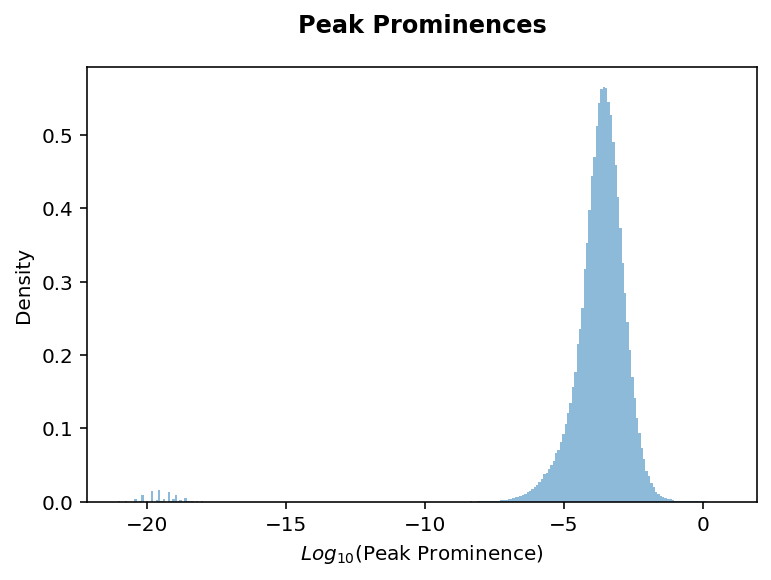

In [22]:
plt.hist(peak_prominences_for_pd4_log, bins=256, density=True, alpha=0.5)
plt.title("Peak Prominences", fontweight="bold", y=1.05)
plt.xlabel(r"$Log_{10}$(Peak Prominence)")
plt.ylabel(f"Density")
plt.show()

In [23]:
def peak_detection_inecik_4(gene_id, threshold, window="hanning", window_len=25, wlen=290):
    try:
        exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
        tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
        exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        assert exp_rpkm > 1 and tra_rpkm > 1
        assert len(exp_rpm_bs) > window_len
        rpm_gene = I.riboseq_sixtymers.translatome.calculate_rpm_genes(gene_id)
        exp_rpm_s = smooth_array(exp_rpm_bs, window_len=window_len, window=window) / rpm_gene
        # Calculations
        peaks, _ = find_peaks(exp_rpm_s)
        calc_prominences = peak_prominences(exp_rpm_s, peaks=peaks, wlen=wlen)
        return peaks[np.log10(calc_prominences[0]) > threshold]
    except AssertionError:
        return np.array([])

In [24]:
# Example usage
gene_id = I.gene_list[0]
threshold_4 = np.percentile(peak_prominences_for_pd4_log, 95)
peaks_example = peak_detection_inecik_4(gene_id, threshold_4)
print(f"Peaks for {gene_id}: {peaks_example}")
print(f"Threshold: {round(threshold_4, 4)}")

Peaks for ENSG00000000003: [ 54 210]
Threshold: -2.4465


### Peak Detection 3: 

It depends on the idea explained previous method. However, if we directly multiply width with prominence, we will end up with data, which mostly represents height (actually, prominence), because their scale is very different (prominence values are very small in general). This is okay because the highest width is assigned to the largest peak for a given are. Actually, previous method clears up the first methods finding in some sense. For a given, 'wlen', it prioritizes the highest peak. Nevertheless, previous method cannot capture wide peaks First I want to find out probability distributions of both width and prominence, which help me to evaluate cumulative distribution function of a given value. I will use the output in calculation of triangular area.

##### Prominence and width distributions

In [25]:
DISTRIBUTIONS = ["alpha", "anglit", "arcsine", "argus", "beta", "betaprime", "bradford", "burr", "burr12", "cauchy", "chi", "chi2", "cosine", "crystalball", "dgamma", "dweibull", "erlang", "expon", "exponnorm", "exponweib", "exponpow", "f", "fatiguelife", "fisk", "foldcauchy", "foldnorm", "genlogistic", "gennorm", "genpareto", "genexpon", "genextreme", "gausshyper", "gamma", "gengamma", "genhalflogistic", "geninvgauss", "gilbrat", "gompertz", "gumbel_r", "gumbel_l", "halfcauchy", "halflogistic", "halfnorm", "halfgennorm", "hypsecant", "invgamma", "invgauss", "invweibull", "johnsonsb", "johnsonsu", "kappa4", "kappa3", "ksone", "kstwo", "kstwobign", "laplace", "laplace_asymmetric", "levy", "levy_l", "logistic", "loggamma", "loglaplace", "lognorm", "loguniform", "lomax", "maxwell", "mielke", "moyal", "nakagami", "norm", "norminvgauss", "pareto", "pearson3", "powerlaw", "powerlognorm", "powernorm", "rdist", "rayleigh", "rice", "recipinvgauss", "semicircular", "skewnorm", "t", "trapezoid", "triang", "truncexpon", "truncnorm", "uniform", "vonmises", "vonmises_line", "wald", "weibull_min", "weibull_max", "wrapcauchy"]
def universal_fitter(arr, dists, bins, verbose=True):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        result = list()
        for distribution_name in dists:
            if verbose: print(distribution_name, end=": ")
            try:
                distribution = eval("stats." + distribution_name)
                y_exp, x_data = np.histogram(arr, bins, density=True)
                fit_params = distribution.fit(arr)
                y_predicted = distribution.pdf(x_data[:-1], *fit_params)
                mean_sqrt_err = np.sum(np.power(y_predicted - y_exp, 2)) / (len(x_data)-1)
                result.append(mean_sqrt_err)
            except:
                result.append(np.nan)
            if verbose: print(round(mean_sqrt_err, 6), end=" ... Winner: ")
            if verbose: print(DISTRIBUTIONS[result.index(min(result))])
        return result

In [26]:
peak_calculation_z = [[],[]]
for gene_id in I.gene_list:
    exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
    tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
    if exp_rpkm > 1 and tra_rpkm > 1:
        exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        # normalize with translatome rpm
        rpm_gene = I.riboseq_sixtymers.translatome.calculate_rpm_genes(gene_id)
        if len(exp_rpm_bs) > window_len:
            exp_rpm_s = smooth_array(exp_rpm_bs, window_len=25, window="hanning") / rpm_gene
            peaks, _ = find_peaks(exp_rpm_s)
            calc_prominences = peak_prominences(exp_rpm_s, peaks=peaks, wlen=290)
            calc_witdhs = peak_widths(exp_rpm_s, rel_height=1, peaks=peaks, prominence_data=calc_prominences, wlen=290)
            peak_calculation_z[0].extend(list(calc_prominences[0]))
            peak_calculation_z[1].extend(list(calc_witdhs[0]))

In [27]:
a, b = peak_calculation_z
a, b = np.array(a), np.array(b)
la = np.log(a)
c = la > -18  # It is basically floating point errors etc
a, b, la = a[c], b[c], la[c]

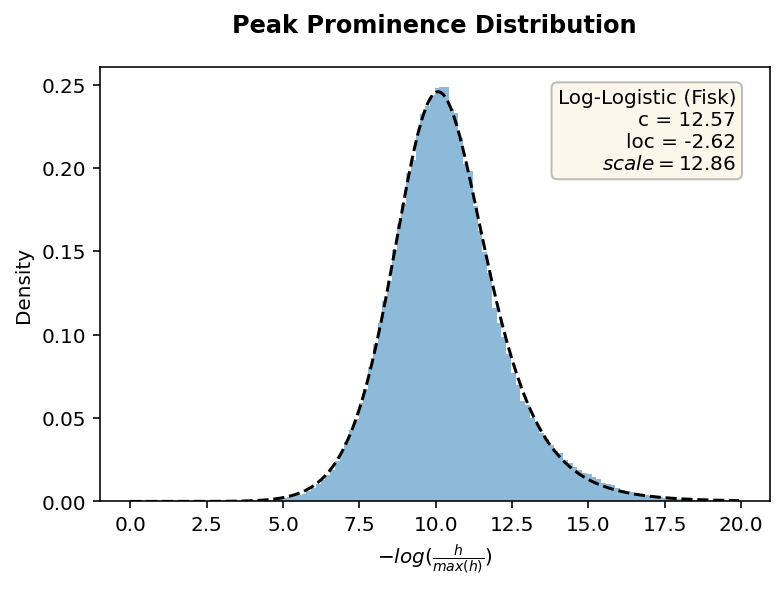

In [28]:
params_h_additional = a.max()
d = -np.log(a/a.max())
# Below code was actually run. The result was 'fisk'. It takes so long so commented out.
# res_d = universal_fitter(d, DISTRIBUTIONS, 512, verbose=False)
# distribution = eval("stats." + "DISTRIBUTIONS[res_d.index(min(res_d))]"
distribution = stats.fisk
params_h  = distribution.fit(d)
x_data_mock = np.linspace(d.min(), d.max(), 256)
y_data_fit = distribution.pdf(x_data_mock, *params_h)
# Plot
plt.hist(d, bins=128, density=True, alpha=0.5)
plt.plot(x_data_mock, y_data_fit, color="black", linestyle='--')
plt.title("Peak Prominence Distribution", fontweight="bold", y=1.05)
plt.ylabel("Density")
plt.xlabel(r"$-log(\frac{h}{max(h)})$")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
textstr = "Log-Logistic (Fisk)\n" + '\n'.join(('c = %.2f' % params_h[0], r'loc = %.2f' % params_h[1], r'$scale = $%.2f' % params_h[2]))
ax = plt.gca()
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, verticalalignment='top', horizontalalignment="right", bbox=props, alpha=1)
plt.show()

Note that smaller values are actually higher peaks.

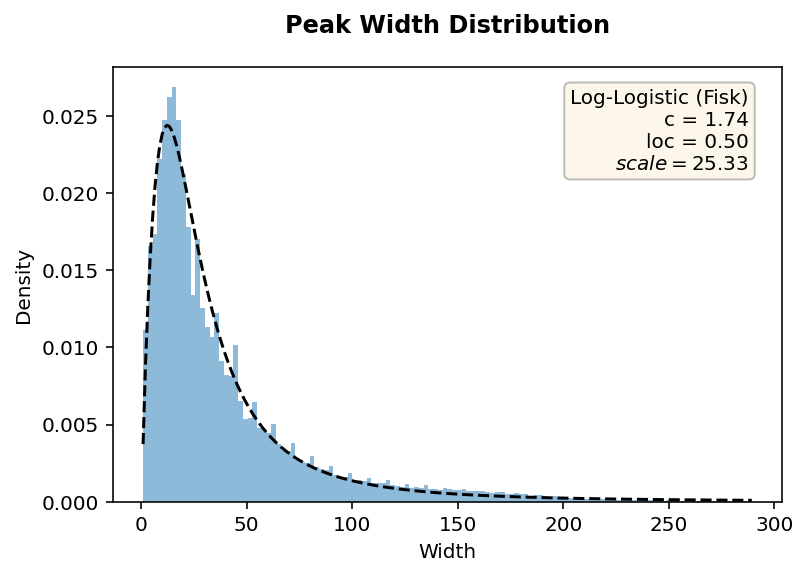

In [29]:
e = b[b != 24]  # It is just a byproduct of the hanning window_len process.
# Below code was actually run. The result was 'fisk'. It takes so long so commented out.
# res_e = universal_fitter(e, DISTRIBUTIONS, 512, verbose=False)
# distribution = eval("stats." + "DISTRIBUTIONS[res.index(min(res))]"
distribution = stats.fisk
params_w  = distribution.fit(e)
x_data_mock = np.linspace(e.min(), e.max(), 256)
y_data_fit = distribution.pdf(x_data_mock, *params_w)
# Plot
plt.hist(e, bins=128, density=True, alpha=0.5)
plt.plot(x_data_mock, y_data_fit, color="black", linestyle='--')
plt.title("Peak Width Distribution", fontweight="bold", y=1.05)
plt.ylabel("Density")
plt.xlabel("Width")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
textstr = "Log-Logistic (Fisk)\n" + '\n'.join(('c = %.2f' % params_w[0], r'loc = %.2f' % params_w[1], r'$scale = $%.2f' % params_w[2]))
ax = plt.gca()
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, verticalalignment='top', horizontalalignment="right", bbox=props, alpha=1)
plt.show()

##### Bivariate distribution of log-logistic (fisk) distributions

At upper left corner, the peaks of interest are found.

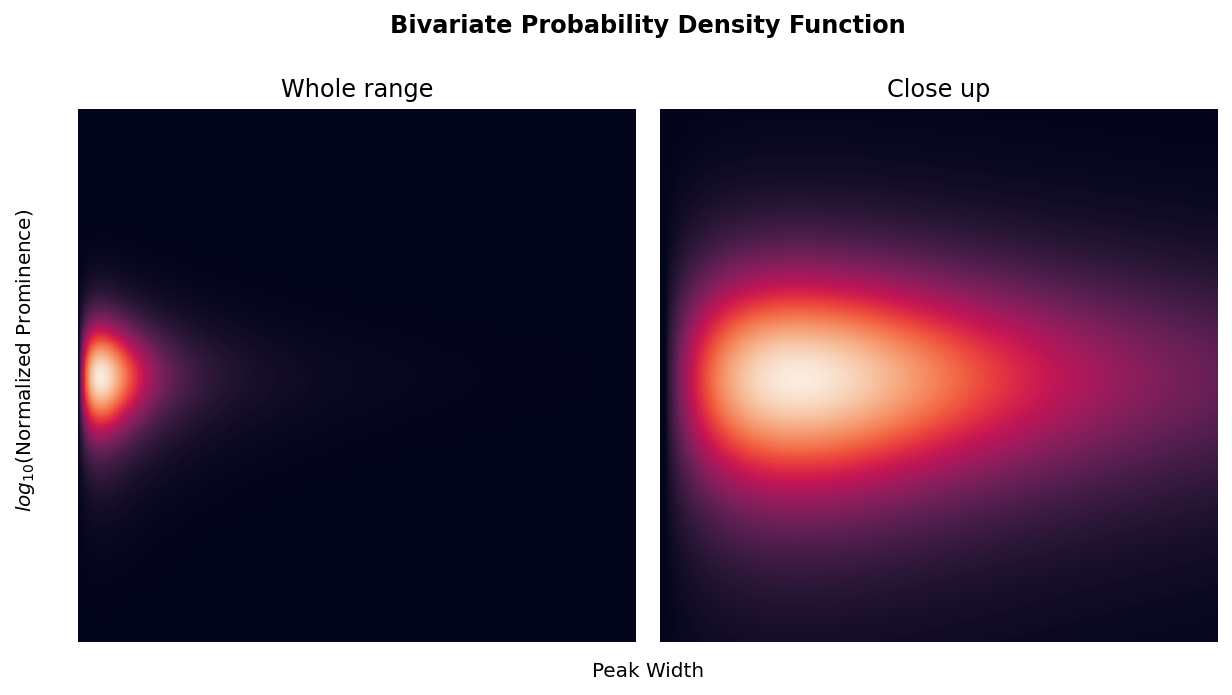

In [30]:
resolution = 1000
fig, ax = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True) 
plt.suptitle("Bivariate Probability Density Function", y=1.1, fontweight="bold")
for i, (y_lims, x_lims) in enumerate(zip(((0, 20), (5,15)), ((0,300), (0,50)))):
    x_data_h = np.linspace(*y_lims, resolution)
    dist_h = stats.fisk.pdf(x_data_h, *params_h)
    x_data_w = np.linspace(*x_lims, resolution)
    dist_w = stats.fisk.pdf(x_data_w, *params_w)
    dist_h = dist_h.reshape(resolution, 1)
    dist_w = dist_w.reshape(1, resolution)
    matrice = (dist_h.reshape(resolution, 1) * dist_w.reshape(1, resolution))
    matrice = pd.DataFrame(matrice, columns=map(int, x_data_w), index=map(int, x_data_h))
    sns.heatmap(matrice, ax=ax[i], xticklabels=False, yticklabels=False, cbar=False)
fig.text(0.5, - 0.05, 'Peak Width', ha='center')
fig.text(-0.05, 0.5, "$log_{10}$(Normalized Prominence)", va='center', rotation='vertical')
ax[0].set_title("Whole range", y=1.1)
ax[1].set_title("Close up", y=1.1)
plt.show()

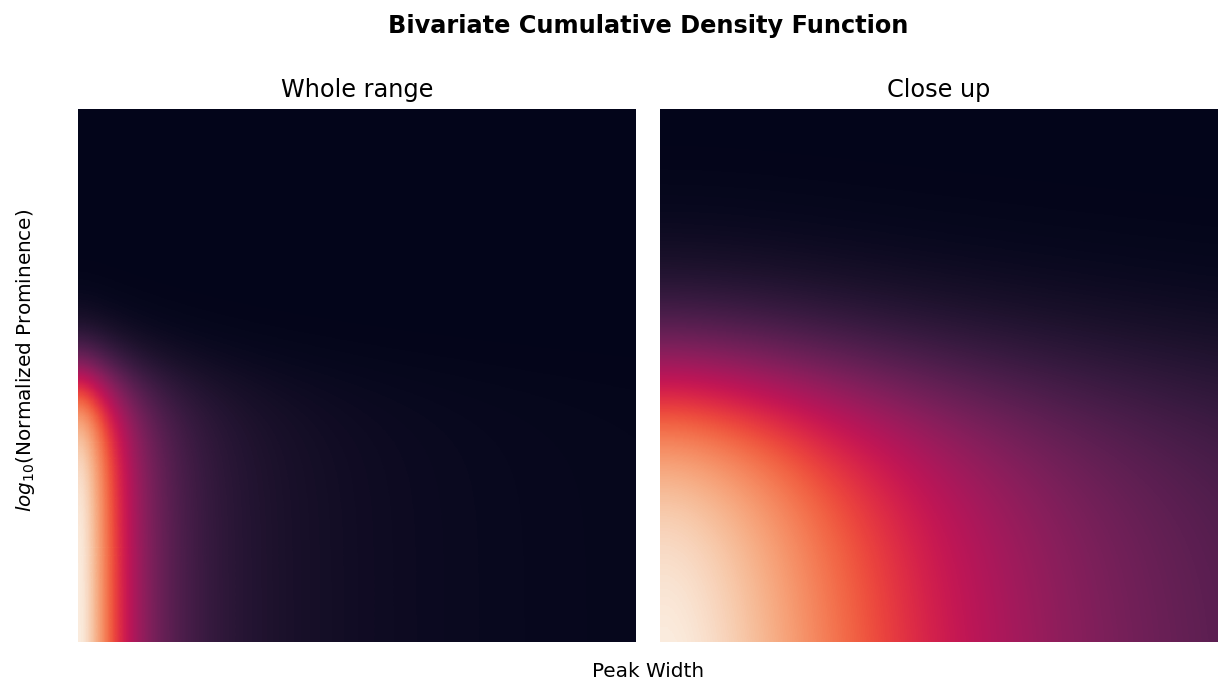

In [31]:
resolution = 1000
fig, ax = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True) 
plt.suptitle("Bivariate Cumulative Density Function", y=1.1, fontweight="bold")
for i, (y_lims, x_lims) in enumerate(zip(((0, 20), (5,15)), ((0,300), (0,50)))):
    x_data_h = np.linspace(*y_lims, resolution)
    dist_h = stats.fisk.cdf(x_data_h, *params_h)
    x_data_w = np.linspace(*x_lims, resolution)
    dist_w = 1 - stats.fisk.cdf(x_data_w, *params_w)
    dist_h = dist_h.reshape(resolution, 1)
    dist_w = dist_w.reshape(1, resolution)
    matrice = (dist_h.reshape(resolution, 1) * dist_w.reshape(1, resolution))
    matrice = pd.DataFrame(matrice, columns=map(int, x_data_w), index=map(int, x_data_h))
    sns.heatmap(matrice, ax=ax[i], xticklabels=False, yticklabels=False, cbar=False)
fig.text(0.5, - 0.05, 'Peak Width', ha='center')
fig.text(-0.05, 0.5, "$log_{10}$(Normalized Prominence)", va='center', rotation='vertical')
ax[0].set_title("Whole range", y=1.1)
ax[1].set_title("Close up", y=1.1)
plt.show()

The peaks at upper left are the peaks we are interested in.

##### Prominence and width distributions

In [32]:
def probability_prominence(x, params_h_additional, params):
    x_logged = -np.log(x/params_h_additional)
    cumulative_prob = stats.fisk.cdf(x_logged, *params)  # because smaller values are higher peaks
    return cumulative_prob

def probability_width(x, params):
    cumulative_prob = stats.fisk.cdf(x, *params)
    return 1 - cumulative_prob  # essentially this is survival function

In [33]:
def peak_detection_inecik_3(gene_id, threshold, par_h_a, par_h, par_w,
                            window="hanning", window_len=25, wlen=290):
    try:
        exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
        tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
        exp_rpm_bs = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        assert exp_rpkm > 1 and tra_rpkm > 1
        assert len(exp_rpm_bs) > window_len
        rpm_gene = I.riboseq_sixtymers.translatome.calculate_rpm_genes(gene_id)
        exp_rpm_s = smooth_array(exp_rpm_bs, window_len=window_len, window=window) / rpm_gene
        peaks, _ = find_peaks(exp_rpm_s)
        calc_prominences = peak_prominences(exp_rpm_s, peaks=peaks, wlen=wlen)
        calc_witdhs = peak_widths(exp_rpm_s, rel_height=1, peaks=peaks, prominence_data=calc_prominences, wlen=wlen)
        peak_prominence_probs = probability_prominence(calc_prominences[0], par_h_a, par_h)
        peak_witdhs_probs = probability_width(calc_witdhs[0], par_w)
        bivariate_cumulative = peak_prominence_probs * peak_witdhs_probs
        thresholded = bivariate_cumulative < threshold        
        return peaks[thresholded]
    except AssertionError:
        return np.array([])
# Array'in başına ve sonuna 0 ekle çünkü baş ve sondaki pikleri algılamıyor

In [34]:
# Example usage
gene_id = I.gene_list[0]
threshold_3 = 0.005
peaks_example = peak_detection_inecik_3(gene_id, threshold_3, params_h_additional, params_h, params_w)
print(f"Peaks for {gene_id}: {peaks_example}")
print(f"Threshold: {round(threshold_3, 4)}")

Peaks for ENSG00000000003: [ 54 210]
Threshold: 0.005


## Visualization of Peak Detection methods

In [35]:
def find_gene_with_large_rpkm(selected_gene_list):
    while True:
        gene_id = random.choice(I.riboseq_sixtymers.gene_list)
        total_exp = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
        total_tra = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
        if total_exp > 1 and total_tra > 1 and gene_id not in selected_gene_list:
            return total_exp, total_tra, gene_id    

def random_gene_list_creator(gene_number):
    plot_gene = list()
    gene_id_list = list()
    for _ in range(gene_number):
        gene_info = find_gene_with_large_rpkm(gene_id_list)
        plot_gene.append(gene_info)
        gene_id_list.append(gene_info[2])
    return plot_gene

def start_gene_list_creator(gene_number, start_from):
    plot_gene = list()
    counter = 0
    while len(plot_gene) != gene_number:
        gene_id = I.gene_list[start_from + counter]
        total_exp = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
        total_tra = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
        if total_exp > 1 and total_tra > 1:
            plot_gene.append((total_exp, total_tra, gene_id),)
        counter += 1
    return plot_gene

def see_examples(function, gene_list_plot, the_title, *args, **kwargs):
    x, y = 1, 2
    fig, axes = plt.subplots(x, y, figsize=(y * 7, x * 2))
    fig.suptitle(the_title, y=1.1, fontweight="bold")
    counter = 0
    for i1 in range(axes.shape[0]):
        total_exp, total_tra, gene_id = gene_list_plot[counter]
        counter += 1
        rpm_tra = I.riboseq_sixtymers.translatome.calculate_rpm_genes(gene_id)
        arr = smooth_array(I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id), window_len=25, window="hanning") / rpm_tra
        peaks = function(gene_id, *args, **kwargs)
        #axes[i1][i2].vlines(peaks, arr.min(),arr.max(), color="green", linestyle="--", linewidth=3)
        axes[i1].plot(arr, alpha=1, color="salmon")
        axes[i1].scatter(peaks, [arr[p] for p in peaks], color="black", alpha=1, s=25)
        axes[i1].set_ylim(0, arr.max() * 1.35)
        axes[i1].text(0.01, 0.99, f"{gene_id} / Index {I.gene_list.index(gene_id)}\nRPKMs: {round(total_exp,2)} - {round(total_tra,2)}", fontsize=6, transform=axes[i1].transAxes, verticalalignment='top', horizontalalignment="left")
        axes[i1].text(0.99, 0.99, f"Max: {round(arr.max(),5)}\nPeaks: {len(peaks)}", fontsize=6, transform=axes[i1].transAxes, verticalalignment='top', horizontalalignment="right")
        axes[i1].axes.get_yaxis().set_visible(False)
        axes[i1].tick_params(labelsize=6)
    plt.tight_layout()
    plt.show()

Threshold 1: 0.00246
Threshold 2: 0.11651
Threshold 3: 0.02
Threshold 4: -2.70908


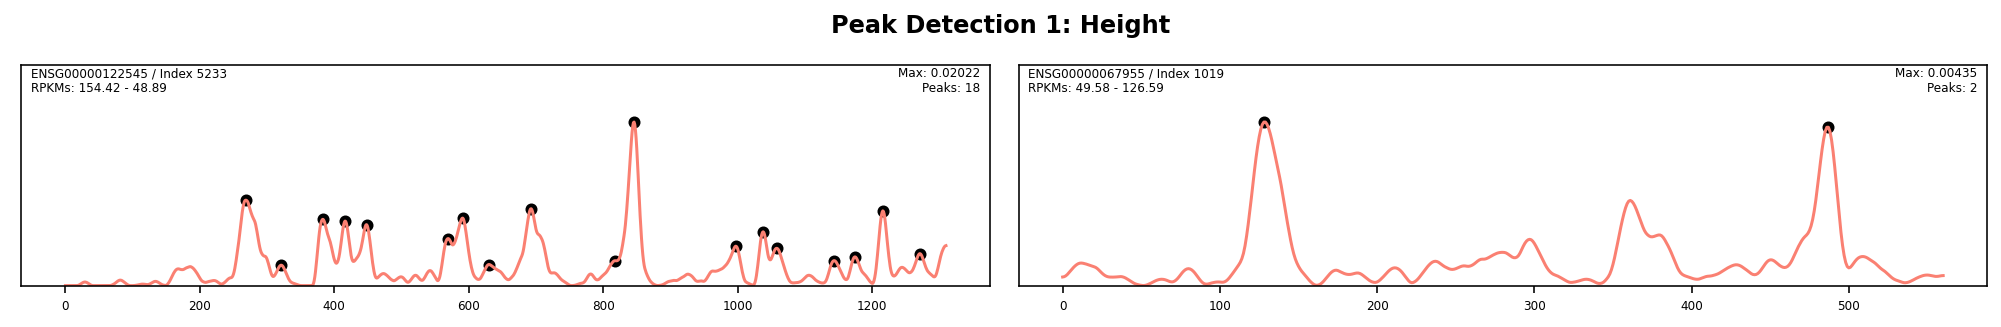

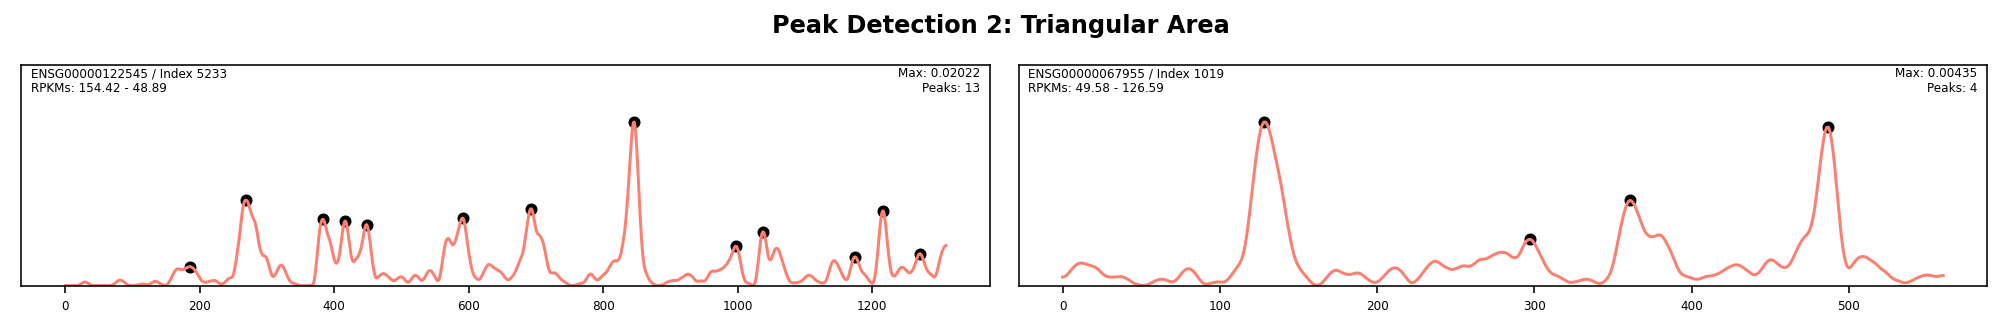

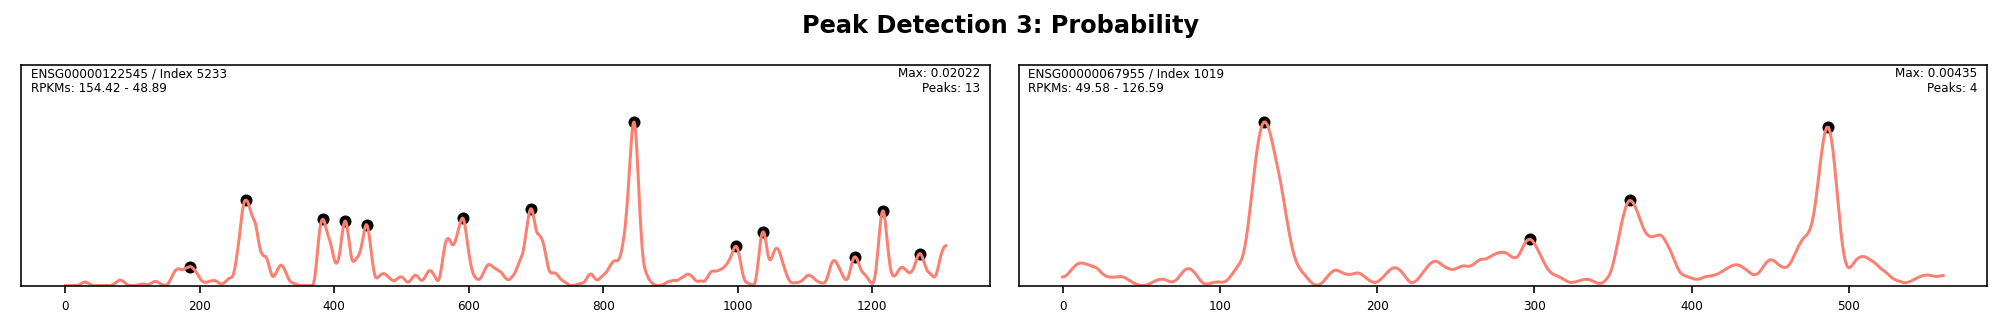

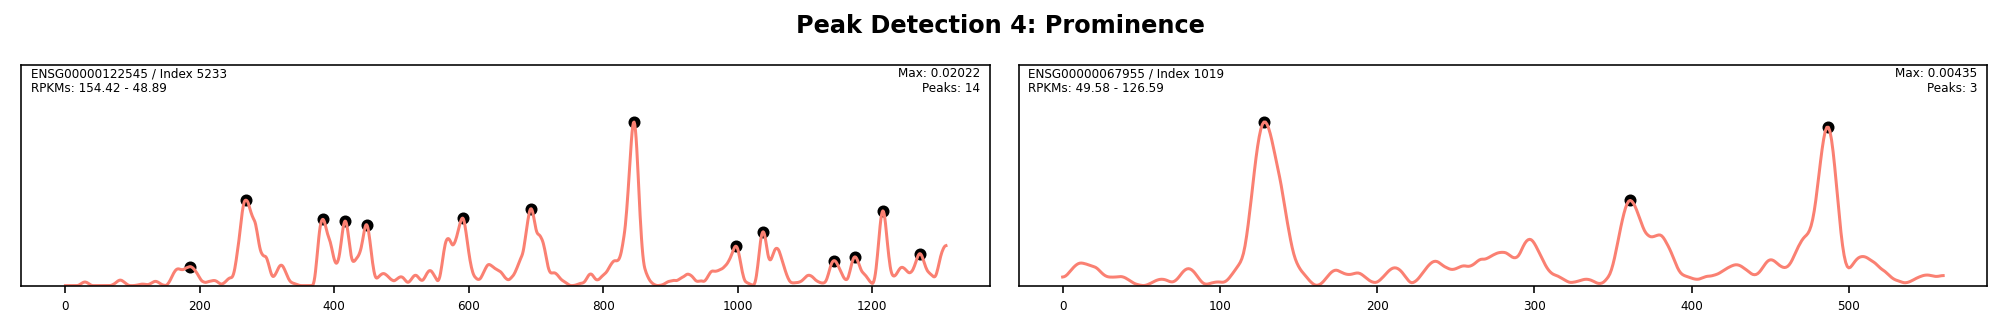

In [51]:
threshold_1 = np.percentile(log_peak_height_for_1, 90)
threshold_2 = np.percentile(log_peak_height_for_2, 90)
threshold_3 = 0.02
threshold_4 = np.percentile(peak_prominences_for_pd4_log, 90)
print(f"Threshold 1: {round(10**threshold_1, 5)}\n"
      f"Threshold 2: {round(10**threshold_2, 5)}\n" 
      f"Threshold 3: {round(threshold_3, 5)}\n"
      f"Threshold 4: {round(threshold_4, 5)}")
#gene_list_plot = start_gene_list_creator(2, 20)
gene_list_plot = random_gene_list_creator(2)
see_examples(peak_detection_inecik_1, gene_list_plot, "Peak Detection 1: Height", threshold_1)
see_examples(peak_detection_inecik_2, gene_list_plot, "Peak Detection 2: Triangular Area", threshold_2)
see_examples(peak_detection_inecik_3, gene_list_plot, "Peak Detection 3: Probability", threshold_3, params_h_additional, params_h, params_w)
see_examples(peak_detection_inecik_4, gene_list_plot, "Peak Detection 4: Prominence", threshold_4)

#### Response curves of the peak detection tools

In [37]:
data_point = 40
perc_range = np.logspace(np.log10(99), np.log10(50), data_point)
prob_range = np.logspace(np.log10(0.001), np.log10(0.5), data_point)
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_peak_detection_response.joblib")
try:  # Because it takes very long, as written very inefficiently.
    perc_all_1, perc_all_2, perc_all_3, perc_all_4 = joblib.load(save_metadata_path)
except FileNotFoundError:
    perc_all_1, perc_all_2, perc_all_3, perc_all_4 = list(), list(), list(), list()
    for l in range(data_point):
        threshold_1 = np.percentile(log_peak_height_for_1, perc_range[l])
        threshold_2 = np.percentile(log_peak_height_for_2, perc_range[l])
        threshold_3 = prob_range[l]
        threshold_4 = np.percentile(peak_prominences_for_pd4_log, perc_range[l])
        perc_peaks_1, perc_peaks_2, perc_peaks_3, perc_peaks_4 = list(), list(), list(), list()
        for gene_id in I.gene_list:
            exp_rpkm = I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id)
            tra_rpkm = I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id)
            if exp_rpkm < 1 or tra_rpkm < 1 or I.riboseq_sixtymers.translatome.gene_lengths[gene_id] < 25:
                continue 
            perc_peaks_1.append(len(peak_detection_inecik_1(gene_id, threshold_1)))
            perc_peaks_2.append(len(peak_detection_inecik_2(gene_id, threshold_2)))
            perc_peaks_3.append(len(peak_detection_inecik_3(gene_id, threshold_3, params_h_additional, params_h, params_w)))
            perc_peaks_4.append(len(peak_detection_inecik_4(gene_id, threshold_4)))
        perc_all_1.append(perc_peaks_1)
        perc_all_2.append(perc_peaks_2)
        perc_all_3.append(perc_peaks_3)
        perc_all_4.append(perc_peaks_4)
    perc_all_1 = np.array(perc_all_1)
    perc_all_2 = np.array(perc_all_2)
    perc_all_3 = np.array(perc_all_3)
    perc_all_4 = np.array(perc_all_4)
    joblib.dump((perc_all_1, perc_all_2, perc_all_3, perc_all_4), save_metadata_path)

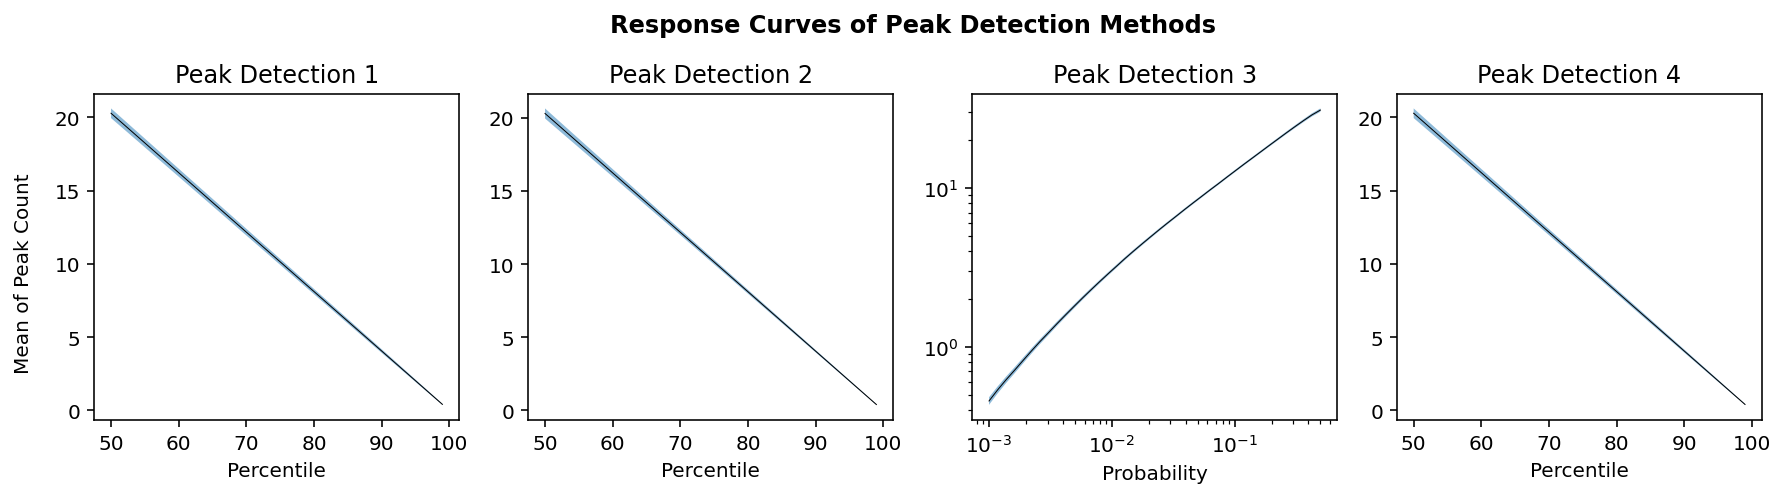

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True) 
plt.suptitle("Response Curves of Peak Detection Methods", y=1.1, fontweight="bold")
for i in range(4):
    x_data = perc_range if i != 2 else prob_range
    arr = eval(f"perc_all_{i+1}.T")
    # Statistics
    y_data = np.nanmean(arr, axis=0)
    se = np.array(stats.sem(arr, nan_policy='omit')) # standard error
    n = len(arr) - np.sum(np.isnan(arr), axis=0)
    ci_l, ci_h = stats.t.interval(CONFIDENCE, n-1, loc=y_data, scale=se)
    # Plot
    ax[i].plot(x_data, y_data, linewidth=0.5, color="black")
    ax[i].fill_between(x_data, ci_l, ci_h, alpha=0.5)
    ax[i].set_title(f"Peak Detection {i+1}")
    if i == 2:
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
ax[0].set_xlabel('Percentile')
ax[1].set_xlabel('Percentile')
ax[2].set_xlabel('Probability')
ax[3].set_xlabel('Percentile')
fig.text(-0.02, 0.5, "Mean of Peak Count", va='center', rotation='vertical')
plt.show()

## Notes for me

In [39]:
# NOTE: Confidence intervalleri hesaplarken normal değil fisk dağıldığını varsayalım...
#plt.hist(np.nanmean(arr, axis=1), bins=256);
#stats.fisk.interval(1,1);

In [40]:
# distribution of tt and s, peak'leri için, 
# how much they correlate?

In [41]:
# bu ilk elbow finding'de neden "flat'ı seçtin amk", belki hanning 25 olunca daha az olacak??

In [42]:
## Normalize then do stuf.

In [43]:
# rpkm vs length for experiment sixtymers

In [44]:
# update parameteres in main.py

In [45]:
# todo: a jupyter notebook aç
# - distribution of stallings
# - dist of tt
# - birbirlerine oranı'nın grafiği: correlasyon ve oranların distribution'u
# ne kadar base, ssig ve dsig var


# posizyonlar ne oranda correle oluyor: tt_stalling vs monosome
# genlerin toplam ne oranda correle oluyor: 


# tt'nin average rpkm'i kaç, bir threshold belirle, altındaki genleri disregard et

# önce fixed gaussian'la şeyap
# sonra normalize
# bütün genomdeaki bütün peak'in average genişliği ve uzunluğu kaç
# bundan significantly sapan peak'leri peak diye seç, ya da threshold belirle istatistiki olarak.
# aynısını gen içerisinde peak'leri seçerek de yap